# Unzip GTZAN playlist

In [7]:
import zipfile
import os

# Define the path to the zip file and the destination directory
zip_file_path = '../cache/gtzan/archive.zip'
unpack_dir = '../cache/gtzan/'

# Create the destination directory if it doesn't exist
os.makedirs(unpack_dir, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(unpack_dir)

print(f"Contents unpacked to {unpack_dir}")


Contents unpacked to ../cache/gtzan/


# Calculate Features

In [37]:
# Import necessary libraries
import os
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm

# Initialize a list to store the feature data
data = []

ssd_cap = 200
ssd_looper = 0
gtzan_cap = 100
gtzan_looper = 0



# Function to extract features from a given .wav file
def extract_features(file_path, label):
    try:
        y, sr = librosa.load(file_path, sr=16000)

        # Extract features
        length = librosa.get_duration(y=y, sr=sr)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        rms = librosa.feature.rms(y=y)
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zero_crossing_rate = librosa.feature.zero_crossing_rate(y)
        harmony = librosa.effects.harmonic(y)
        perceptr = librosa.effects.percussive(y)
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)

        # Calculate ASR (Articulation Feature)
        rms_energy = rms[0]
        asr = np.sum(rms_energy < np.mean(rms_energy)) / len(rms_energy)

        # Calculate Onset Envelope Features
        onset_env = librosa.onset.onset_strength(y=y, sr=sr)
        oenv_mean = np.mean(onset_env)
        oenv_var = np.var(onset_env)
        oenv_std = np.std(onset_env)

        # Calculate Spectral Flatness Features
        flatness = librosa.feature.spectral_flatness(y=y)
        flatness_mean = np.mean(flatness)
        flatness_var = np.var(flatness)
        flatness_std = np.std(flatness)

        # Aggregate features
        features = [
            os.path.basename(file_path),
            length,
            np.mean(chroma_stft), np.var(chroma_stft),
            np.mean(rms), np.var(rms), np.std(rms),
            np.mean(spectral_centroid), np.var(spectral_centroid),
            np.mean(spectral_bandwidth), np.var(spectral_bandwidth),
            np.mean(rolloff), np.var(rolloff), np.std(rolloff),
            np.mean(zero_crossing_rate), np.var(zero_crossing_rate),
            np.mean(harmony), np.var(harmony),
            np.mean(perceptr), np.var(perceptr),
            tempo[0],
            asr,
            oenv_mean, oenv_var, oenv_std,
            flatness_mean, flatness_var, flatness_std
        ]

        # Add MFCC features (only means as per the paper)
        for i in range(20):
            features.append(np.mean(mfcc[i]))

        # Append the label
        features.append(label)

        return features
    
    except Exception as e:
        # If an error occurs, print the error and skip this file
        print(f"Error processing {file_path}: {e}")
        return None
    
def loop_over_dir(dir_name):
    
    def get_label(dir_name):
        if 'sleep' in dir_name: return 'sleep'
        elif 'fma_pop' in dir_name: return 'FMA POP'
        elif 'musiccaps' in dir_name: return 'MusicCaps' 
        elif 'drum' in dir_name: return 'Drum Samples'
    
    if 'gtzan' in dir_name:
        for genre in os.listdir(dir_name):
            genre_dir = os.path.join(dir_name, genre)
            if os.path.isdir(genre_dir):
                gtzan_looper = 0
                for filename in tqdm(os.listdir(genre_dir), desc=f'Processing GTZAN dataset genre: {genre_dir}'):
                    if gtzan_looper < gtzan_cap:
                        if filename.endswith(('.wav', '.mp3')):
                            file_path = os.path.join(genre_dir, filename)
                            features = extract_features(file_path, label=genre)
                            if features is not None:  # Skip files that failed to process
                                data.append(features)
                                gtzan_looper += 1
    else:
        ssd_looper = 0
        for filename in tqdm(os.listdir(dir_name), desc=f'Processing {dir_name} dataset'):
            if ssd_looper < ssd_cap:
                if filename.endswith(('.wav', '.mp3')):
                    file_path = os.path.join(dir_name, filename)
                    features = extract_features(file_path, label=get_label(dir_name))
                    if features is not None:  # Skip files that failed to process
                        data.append(features)
                        ssd_looper += 1

# Directory paths
spotify_directory = '../cache/spotify_sleep_dataset/waveform'
gtzan_directory = '../cache/gtzan/Data/genres_original'
fma_pop_directory = '../cache/fma_pop/waveform/'
musiccaps_directory = '../cache/musiccaps/waveform'
drum_samples_directory = '../cache/drum_samples/waveform'

for dir_name in [fma_pop_directory, musiccaps_directory, drum_samples_directory]:
    loop_over_dir(dir_name)

# Define column names
columns = [
    'filename', 'length', 'chroma_stft_mean', 'chroma_stft_var',
    'rms_mean', 'rms_var', 'rms_std', 'spectral_centroid_mean', 'spectral_centroid_var',
    'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean', 'rolloff_var', 'rolloff_std',
    'zero_crossing_rate_mean', 'zero_crossing_rate_var', 'harmony_mean', 'harmony_var',
    'perceptr_mean', 'perceptr_var', 'tempo', 'asr',
    'oenv_mean', 'oenv_var', 'oenv_std',
    'flatness_mean', 'flatness_var', 'flatness_std'
]

# Add MFCC columns
for i in range(1, 21):
    columns.append(f'mfcc{i}_mean')

# Add label column
columns.append('label')

# Create a DataFrame and save to CSV
df = pd.DataFrame(data, columns=columns)
df.to_csv('musical_features_rest.csv', index=False)

print('Feature extraction complete. Saved to musical_features.csv')


Processing ../cache/fma_pop/waveform/ dataset:   0%|          | 0/7997 [00:00<?, ?it/s]

Processing ../cache/musiccaps/waveform dataset: 100%|██████████| 5410/5410 [05:38<00:00, 15.99it/s] 
Processing ../cache/drum_samples/waveform dataset:   0%|          | 1/1549 [00:00<04:57,  5.20it/s]

Error processing ../cache/drum_samples/waveform/sample_51.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:   0%|          | 7/1549 [00:00<02:57,  8.67it/s]

Error processing ../cache/drum_samples/waveform/sample_4.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_370.wav: 'float' object is not subscriptable


/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1909
  warnings.warn(
/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
Processing ../cache/drum_samples/waveform dataset:   1%|          | 10/1549 [00:01<02:38,  9.71it/s]

Error processing ../cache/drum_samples/waveform/sample_711.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:   1%|          | 15/1549 [00:02<03:48,  6.73it/s]

Error processing ../cache/drum_samples/waveform/sample_1327.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:   1%|          | 17/1549 [00:02<03:08,  8.15it/s]/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2001
  warnings.warn(


Error processing ../cache/drum_samples/waveform/sample_285.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_950.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_522.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:   1%|          | 19/1549 [00:02<02:37,  9.74it/s]

Error processing ../cache/drum_samples/waveform/sample_254.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_981.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:   1%|▏         | 21/1549 [00:02<03:01,  8.42it/s]

Error processing ../cache/drum_samples/waveform/sample_1030.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:   2%|▏         | 24/1549 [00:03<03:33,  7.13it/s]/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2003
  warnings.warn(
Processing ../cache/drum_samples/waveform dataset:   2%|▏         | 28/1549 [00:03<02:25, 10.45it/s]

Error processing ../cache/drum_samples/waveform/sample_1168.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_1509.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_1320.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:   2%|▏         | 30/1549 [00:03<03:15,  7.75it/s]

Error processing ../cache/drum_samples/waveform/sample_1487.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_144.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:   2%|▏         | 32/1549 [00:04<03:23,  7.46it/s]/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1648
  warnings.warn(
Processing ../cache/drum_samples/waveform dataset:   2%|▏         | 34/1549 [00:04<02:47,  9.06it/s]

Error processing ../cache/drum_samples/waveform/sample_957.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_282.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_253.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:   2%|▏         | 38/1549 [00:04<02:40,  9.42it/s]

Error processing ../cache/drum_samples/waveform/sample_195.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_632.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:   3%|▎         | 45/1549 [00:05<03:08,  7.98it/s]

Error processing ../cache/drum_samples/waveform/sample_3.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_87.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:   3%|▎         | 48/1549 [00:06<03:30,  7.14it/s]

Error processing ../cache/drum_samples/waveform/sample_377.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:   3%|▎         | 50/1549 [00:06<03:19,  7.51it/s]

Error processing ../cache/drum_samples/waveform/sample_1204.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:   3%|▎         | 52/1549 [00:06<04:53,  5.09it/s]

Error processing ../cache/drum_samples/waveform/sample_873.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:   3%|▎         | 54/1549 [00:07<04:24,  5.66it/s]

Error processing ../cache/drum_samples/waveform/sample_1489.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_959.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:   4%|▎         | 57/1549 [00:07<03:12,  7.75it/s]

Error processing ../cache/drum_samples/waveform/sample_1039.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:   4%|▍         | 59/1549 [00:07<03:06,  7.97it/s]

Error processing ../cache/drum_samples/waveform/sample_1458.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_305.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_1161.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:   4%|▍         | 62/1549 [00:08<03:15,  7.62it/s]/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2045
  warnings.warn(
Processing ../cache/drum_samples/waveform dataset:   5%|▍         | 70/1549 [00:09<03:22,  7.31it/s]

Error processing ../cache/drum_samples/waveform/sample_1094.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_557.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:   5%|▍         | 71/1549 [00:09<03:19,  7.42it/s]

Error processing ../cache/drum_samples/waveform/sample_58.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:   5%|▍         | 74/1549 [00:10<04:35,  5.36it/s]

Error processing ../cache/drum_samples/waveform/sample_221.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_586.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:   5%|▍         | 76/1549 [00:10<03:11,  7.69it/s]

Error processing ../cache/drum_samples/waveform/sample_89.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_1045.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:   5%|▌         | 79/1549 [00:10<03:10,  7.71it/s]

Error processing ../cache/drum_samples/waveform/sample_1424.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:   5%|▌         | 82/1549 [00:11<04:18,  5.69it/s]

Error processing ../cache/drum_samples/waveform/sample_718.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_1355.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_131.wav: 'float' object is not subscriptable


/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1223
  warnings.warn(
Processing ../cache/drum_samples/waveform dataset:   5%|▌         | 84/1549 [00:11<03:31,  6.93it/s]

Error processing ../cache/drum_samples/waveform/sample_1093.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:   6%|▌         | 89/1549 [00:12<03:24,  7.15it/s]

Error processing ../cache/drum_samples/waveform/sample_581.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_226.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:   6%|▌         | 91/1549 [00:12<03:15,  7.46it/s]

Error processing ../cache/drum_samples/waveform/sample_1042.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:   6%|▌         | 93/1549 [00:12<03:02,  7.99it/s]

Error processing ../cache/drum_samples/waveform/sample_1384.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_1423.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:   6%|▋         | 97/1549 [00:13<02:21, 10.28it/s]

Error processing ../cache/drum_samples/waveform/sample_1329.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_302.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:   6%|▋         | 99/1549 [00:13<02:18, 10.48it/s]

Error processing ../cache/drum_samples/waveform/sample_1166.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_763.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:   7%|▋         | 103/1549 [00:13<03:05,  7.79it/s]

Error processing ../cache/drum_samples/waveform/sample_474.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_806.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:   7%|▋         | 105/1549 [00:14<02:59,  8.07it/s]

Error processing ../cache/drum_samples/waveform/sample_672.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:   7%|▋         | 107/1549 [00:14<02:54,  8.25it/s]

Error processing ../cache/drum_samples/waveform/sample_213.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_1077.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:   7%|▋         | 112/1549 [00:14<02:33,  9.34it/s]

Error processing ../cache/drum_samples/waveform/sample_1360.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_104.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:   7%|▋         | 115/1549 [00:15<02:59,  7.97it/s]

Error processing ../cache/drum_samples/waveform/sample_16.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:   8%|▊         | 118/1549 [00:15<03:04,  7.76it/s]

Error processing ../cache/drum_samples/waveform/sample_441.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_833.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:   8%|▊         | 121/1549 [00:16<02:42,  8.77it/s]

Error processing ../cache/drum_samples/waveform/sample_787.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_756.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:   8%|▊         | 123/1549 [00:16<02:42,  8.78it/s]/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=431
  warnings.warn(
Processing ../cache/drum_samples/waveform dataset:   8%|▊         | 125/1549 [00:16<02:14, 10.59it/s]

Error processing ../cache/drum_samples/waveform/sample_490.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_337.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:   8%|▊         | 130/1549 [00:17<02:38,  8.94it/s]

Error processing ../cache/drum_samples/waveform/sample_268.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_11.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:   9%|▊         | 132/1549 [00:17<02:55,  8.05it/s]

Error processing ../cache/drum_samples/waveform/sample_834.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_446.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_1243.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:   9%|▊         | 135/1549 [00:17<02:41,  8.74it/s]

Error processing ../cache/drum_samples/waveform/sample_780.wav: 'float' object is not subscriptable


/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=667
  warnings.warn(
Processing ../cache/drum_samples/waveform dataset:   9%|▉         | 137/1549 [00:17<02:09, 10.92it/s]/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=747
  warnings.warn(


Error processing ../cache/drum_samples/waveform/sample_1535.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_1292.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_330.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_497.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:   9%|▉         | 142/1549 [00:18<02:52,  8.14it/s]

Error processing ../cache/drum_samples/waveform/sample_675.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:   9%|▉         | 144/1549 [00:18<02:35,  9.05it/s]

Error processing ../cache/drum_samples/waveform/sample_214.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_1070.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:   9%|▉         | 146/1549 [00:18<02:31,  9.26it/s]

Error processing ../cache/drum_samples/waveform/sample_910.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  10%|▉         | 150/1549 [00:19<02:52,  8.09it/s]

Error processing ../cache/drum_samples/waveform/sample_848.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  10%|█         | 156/1549 [00:20<02:35,  8.97it/s]

Error processing ../cache/drum_samples/waveform/sample_266.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_1002.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_510.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  10%|█         | 158/1549 [00:20<03:03,  7.59it/s]/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1765
  warnings.warn(
Processing ../cache/drum_samples/waveform dataset:  10%|█         | 160/1549 [00:20<02:25,  9.54it/s]

Error processing ../cache/drum_samples/waveform/sample_1315.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_171.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  11%|█         | 166/1549 [00:21<02:25,  9.48it/s]

Error processing ../cache/drum_samples/waveform/sample_846.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  11%|█         | 167/1549 [00:21<02:46,  8.30it/s]

Error processing ../cache/drum_samples/waveform/sample_1231.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  11%|█         | 168/1549 [00:21<03:50,  6.00it/s]

Error processing ../cache/drum_samples/waveform/sample_723.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  11%|█         | 171/1549 [00:22<03:31,  6.51it/s]

Error processing ../cache/drum_samples/waveform/sample_342.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  11%|█         | 173/1549 [00:22<03:22,  6.81it/s]/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1600
  warnings.warn(
Processing ../cache/drum_samples/waveform dataset:  11%|█▏        | 175/1549 [00:22<02:36,  8.78it/s]

Error processing ../cache/drum_samples/waveform/sample_1079.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_64.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  11%|█▏        | 177/1549 [00:22<02:12, 10.32it/s]

Error processing ../cache/drum_samples/waveform/sample_433.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  12%|█▏        | 181/1549 [00:23<03:45,  6.07it/s]

Error processing ../cache/drum_samples/waveform/sample_724.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  12%|█▏        | 183/1549 [00:23<03:11,  7.13it/s]

Error processing ../cache/drum_samples/waveform/sample_345.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_890.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  12%|█▏        | 186/1549 [00:24<02:35,  8.74it/s]

Error processing ../cache/drum_samples/waveform/sample_1121.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_600.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  12%|█▏        | 188/1549 [00:24<02:42,  8.36it/s]

Error processing ../cache/drum_samples/waveform/sample_261.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  12%|█▏        | 190/1549 [00:24<02:49,  8.00it/s]

Error processing ../cache/drum_samples/waveform/sample_965.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  12%|█▏        | 192/1549 [00:24<02:45,  8.20it/s]

Error processing ../cache/drum_samples/waveform/sample_1312.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  13%|█▎        | 195/1549 [00:25<03:07,  7.24it/s]

Error processing ../cache/drum_samples/waveform/sample_789.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_758.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  13%|█▎        | 197/1549 [00:25<03:04,  7.35it/s]/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2000
  warnings.warn(
Processing ../cache/drum_samples/waveform dataset:  13%|█▎        | 199/1549 [00:25<02:27,  9.16it/s]

Error processing ../cache/drum_samples/waveform/sample_735.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  13%|█▎        | 201/1549 [00:26<02:53,  7.78it/s]

Error processing ../cache/drum_samples/waveform/sample_354.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  13%|█▎        | 207/1549 [00:27<03:31,  6.33it/s]

Error processing ../cache/drum_samples/waveform/sample_75.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  13%|█▎        | 209/1549 [00:27<02:55,  7.65it/s]

Error processing ../cache/drum_samples/waveform/sample_1068.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  14%|█▎        | 211/1549 [00:27<03:21,  6.64it/s]/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1876
  warnings.warn(
Processing ../cache/drum_samples/waveform dataset:  14%|█▍        | 213/1549 [00:27<02:48,  7.91it/s]

Error processing ../cache/drum_samples/waveform/sample_798.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_506.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  14%|█▍        | 219/1549 [00:28<02:33,  8.67it/s]

Error processing ../cache/drum_samples/waveform/sample_270.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_488.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  14%|█▍        | 222/1549 [00:29<02:39,  8.32it/s]

Error processing ../cache/drum_samples/waveform/sample_973.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  15%|█▍        | 230/1549 [00:30<03:12,  6.85it/s]/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=986
  warnings.warn(
Processing ../cache/drum_samples/waveform dataset:  15%|█▍        | 232/1549 [00:30<02:44,  8.02it/s]

Error processing ../cache/drum_samples/waveform/sample_1137.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  15%|█▌        | 234/1549 [00:30<02:35,  8.47it/s]

Error processing ../cache/drum_samples/waveform/sample_886.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  15%|█▌        | 238/1549 [00:31<04:26,  4.93it/s]

Error processing ../cache/drum_samples/waveform/sample_1220.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  16%|█▌        | 242/1549 [00:32<02:44,  7.94it/s]

Error processing ../cache/drum_samples/waveform/sample_1283.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_740.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  16%|█▌        | 245/1549 [00:32<02:58,  7.31it/s]

Error processing ../cache/drum_samples/waveform/sample_486.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_321.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  16%|█▌        | 247/1549 [00:33<03:02,  7.12it/s]

Error processing ../cache/drum_samples/waveform/sample_457.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  16%|█▌        | 251/1549 [00:33<02:59,  7.22it/s]

Error processing ../cache/drum_samples/waveform/sample_1252.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  16%|█▋        | 253/1549 [00:33<02:49,  7.64it/s]

Error processing ../cache/drum_samples/waveform/sample_279.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_888.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_1139.wav: 'float' object is not subscriptable


/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1242
  warnings.warn(
Processing ../cache/drum_samples/waveform dataset:  17%|█▋        | 263/1549 [00:35<03:54,  5.48it/s]

Error processing ../cache/drum_samples/waveform/sample_1061.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_205.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  17%|█▋        | 267/1549 [00:35<02:53,  7.38it/s]

Error processing ../cache/drum_samples/waveform/sample_906.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  18%|█▊        | 273/1549 [00:36<02:25,  8.80it/s]

Error processing ../cache/drum_samples/waveform/sample_202.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_1523.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_1284.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  18%|█▊        | 276/1549 [00:37<03:35,  5.91it/s]

Error processing ../cache/drum_samples/waveform/sample_1142.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  18%|█▊        | 278/1549 [00:37<04:15,  4.97it/s]

Error processing ../cache/drum_samples/waveform/sample_326.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  18%|█▊        | 280/1549 [00:38<03:50,  5.50it/s]

Error processing ../cache/drum_samples/waveform/sample_822.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_450.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  18%|█▊        | 286/1549 [00:38<02:12,  9.56it/s]

Error processing ../cache/drum_samples/waveform/sample_508.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_419.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  19%|█▊        | 288/1549 [00:39<02:24,  8.71it/s]

Error processing ../cache/drum_samples/waveform/sample_1053.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_237.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  19%|█▉        | 292/1549 [00:39<02:43,  7.70it/s]

Error processing ../cache/drum_samples/waveform/sample_656.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  19%|█▉        | 294/1549 [00:39<03:02,  6.86it/s]

Error processing ../cache/drum_samples/waveform/sample_687.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_120.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  19%|█▉        | 296/1549 [00:40<03:08,  6.63it/s]

Error processing ../cache/drum_samples/waveform/sample_1344.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_933.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  19%|█▉        | 298/1549 [00:40<02:24,  8.66it/s]/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1783
  warnings.warn(


Error processing ../cache/drum_samples/waveform/sample_1082.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_1260.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  19%|█▉        | 301/1549 [00:40<02:59,  6.97it/s]/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=650
  warnings.warn(
Processing ../cache/drum_samples/waveform dataset:  20%|█▉        | 303/1549 [00:41<02:35,  8.04it/s]/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1470
  warnings.warn(


Error processing ../cache/drum_samples/waveform/sample_1177.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_1516.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  20%|█▉        | 308/1549 [00:41<02:42,  7.65it/s]

Error processing ../cache/drum_samples/waveform/sample_1338.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_32.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  20%|█▉        | 309/1549 [00:42<02:39,  7.77it/s]/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1946
  warnings.warn(
Processing ../cache/drum_samples/waveform dataset:  20%|██        | 311/1549 [00:42<02:12,  9.34it/s]

Error processing ../cache/drum_samples/waveform/sample_462.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_1170.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  20%|██        | 313/1549 [00:42<01:59, 10.34it/s]

Error processing ../cache/drum_samples/waveform/sample_314.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_775.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  20%|██        | 315/1549 [00:42<01:49, 11.29it/s]

Error processing ../cache/drum_samples/waveform/sample_999.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_1028.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  21%|██        | 319/1549 [00:43<02:28,  8.26it/s]

Error processing ../cache/drum_samples/waveform/sample_1498.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  21%|██        | 321/1549 [00:43<02:57,  6.92it/s]

Error processing ../cache/drum_samples/waveform/sample_948.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_368.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  21%|██        | 324/1549 [00:43<02:30,  8.15it/s]

Error processing ../cache/drum_samples/waveform/sample_709.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_1054.wav: 'float' object is not subscriptable


/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1241
  warnings.warn(
Processing ../cache/drum_samples/waveform dataset:  21%|██        | 326/1549 [00:43<02:02, 10.02it/s]

Error processing ../cache/drum_samples/waveform/sample_98.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_230.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  21%|██        | 328/1549 [00:44<02:17,  8.89it/s]

Error processing ../cache/drum_samples/waveform/sample_1435.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  21%|██▏       | 332/1549 [00:44<02:01, 10.01it/s]

Error processing ../cache/drum_samples/waveform/sample_127.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_680.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  22%|██▏       | 334/1549 [00:44<01:51, 10.91it/s]

Error processing ../cache/drum_samples/waveform/sample_934.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_49.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  22%|██▏       | 336/1549 [00:44<02:06,  9.58it/s]

Error processing ../cache/drum_samples/waveform/sample_1085.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  22%|██▏       | 341/1549 [00:45<02:13,  9.04it/s]

Error processing ../cache/drum_samples/waveform/sample_242.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_997.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  22%|██▏       | 343/1549 [00:45<02:28,  8.13it/s]

Error processing ../cache/drum_samples/waveform/sample_184.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  22%|██▏       | 347/1549 [00:46<02:09,  9.26it/s]

Error processing ../cache/drum_samples/waveform/sample_1331.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_293.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  23%|██▎       | 349/1549 [00:46<02:21,  8.46it/s]

Error processing ../cache/drum_samples/waveform/sample_946.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  23%|██▎       | 353/1549 [00:47<02:44,  7.29it/s]

Error processing ../cache/drum_samples/waveform/sample_862.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  23%|██▎       | 354/1549 [00:47<03:02,  6.54it/s]/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=320
  warnings.warn(
Processing ../cache/drum_samples/waveform dataset:  23%|██▎       | 356/1549 [00:47<02:20,  8.52it/s]

Error processing ../cache/drum_samples/waveform/sample_366.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_707.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_96.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  23%|██▎       | 358/1549 [00:47<02:00,  9.85it/s]

Error processing ../cache/drum_samples/waveform/sample_129.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_47.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  23%|██▎       | 363/1549 [00:48<02:34,  7.67it/s]

Error processing ../cache/drum_samples/waveform/sample_417.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  24%|██▎       | 367/1549 [00:49<02:35,  7.61it/s]

Error processing ../cache/drum_samples/waveform/sample_700.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_239.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  24%|██▍       | 370/1549 [00:49<02:51,  6.86it/s]

Error processing ../cache/drum_samples/waveform/sample_658.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_689.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  24%|██▍       | 376/1549 [00:50<01:57,  9.94it/s]

Error processing ../cache/drum_samples/waveform/sample_1518.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_1021.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_990.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  24%|██▍       | 378/1549 [00:50<02:05,  9.36it/s]

Error processing ../cache/drum_samples/waveform/sample_245.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  25%|██▍       | 383/1549 [00:51<02:58,  6.52it/s]

Error processing ../cache/drum_samples/waveform/sample_1336.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_1491.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  25%|██▍       | 387/1549 [00:51<02:43,  7.09it/s]

Error processing ../cache/drum_samples/waveform/sample_294.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_1419.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  25%|██▌       | 389/1549 [00:52<02:20,  8.25it/s]

Error processing ../cache/drum_samples/waveform/sample_1078.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_65.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  25%|██▌       | 393/1549 [00:52<01:56,  9.91it/s]

Error processing ../cache/drum_samples/waveform/sample_432.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  26%|██▌       | 398/1549 [00:52<02:04,  9.26it/s]

Error processing ../cache/drum_samples/waveform/sample_1120.wav: 'float' object is not subscriptable
Error processing ../cache/drum_samples/waveform/sample_891.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset:  26%|██▌       | 399/1549 [00:53<02:02,  9.38it/s]

Error processing ../cache/drum_samples/waveform/sample_344.wav: 'float' object is not subscriptable


Processing ../cache/drum_samples/waveform dataset: 100%|██████████| 1549/1549 [00:53<00:00, 29.09it/s]

Feature extraction complete. Saved to musical_features.csv


In [38]:
features_df = pd.read_csv('musical_features.csv')
feautres_df_rest = pd.read_csv('musical_features_rest.csv')

In [39]:
features_df = pd.concat([features_df, feautres_df_rest])

In [11]:
features_df = pd.read_csv('musical_features.csv')

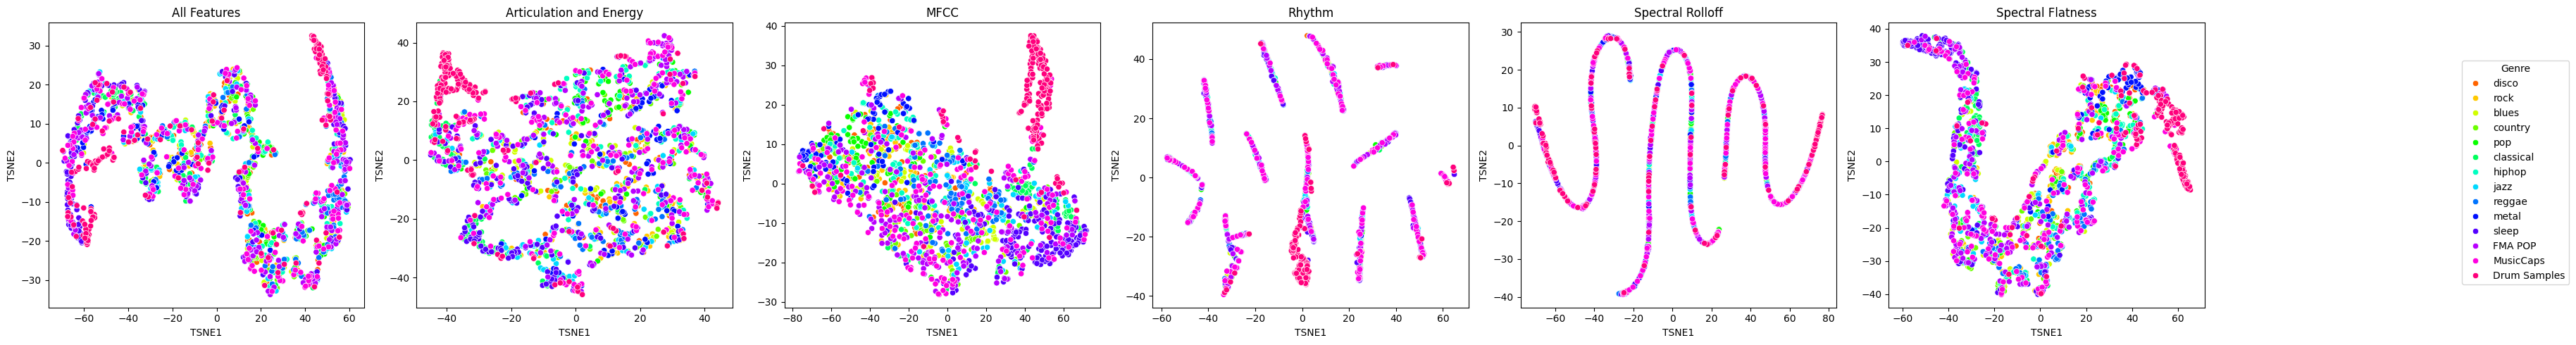

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

# Define feature groups according to the paper
articulation_energy_features = ['asr', 'rms_mean', 'rms_var', 'rms_std']
mfcc_features = [f'mfcc{i}_mean' for i in range(1, 21)]
rhythm_features = ['oenv_mean', 'oenv_var', 'oenv_std', 'tempo']
spectral_rolloff_features = ['rolloff_mean', 'rolloff_var', 'rolloff_std']
spectral_flatness_features = ['flatness_mean', 'flatness_var', 'flatness_std']

# Grouping for visualization
feature_groups = {
    'All Features': features_df.columns[1:-1].tolist(),
    'Articulation and Energy': articulation_energy_features,
    'MFCC': mfcc_features,
    'Rhythm': rhythm_features,
    'Spectral Rolloff': spectral_rolloff_features,
    'Spectral Flatness': spectral_flatness_features
}

# Manually specify a color palette with enough unique colors
unique_labels = features_df['label'].unique()
palette = sns.color_palette("hsv", len(unique_labels))

# Function to plot t-SNE on a given axis
def plot_tsne(ax, features, title):
    X = features_df[features].values
    y = features_df['label'].values
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X)
    
    tsne_df = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
    tsne_df['label'] = y
    
    sns.scatterplot(x='TSNE1', y='TSNE2', hue='label', data=tsne_df, palette=palette, ax=ax)
    ax.set_title(title)
    ax.legend_.remove()  # Remove individual legends

# Create subplots
fig, axs = plt.subplots(1, len(feature_groups), figsize=(35, 5), sharex=False, sharey=False)

# Plot each t-SNE
for ax, (name, features) in zip(axs, feature_groups.items()):
    plot_tsne(ax, features, f'{name}')

# Create a single legend on the right
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', title='Genre', bbox_to_anchor=(1, 0.5), borderaxespad=0.)

plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the layout to make space for the legend
plt.show()


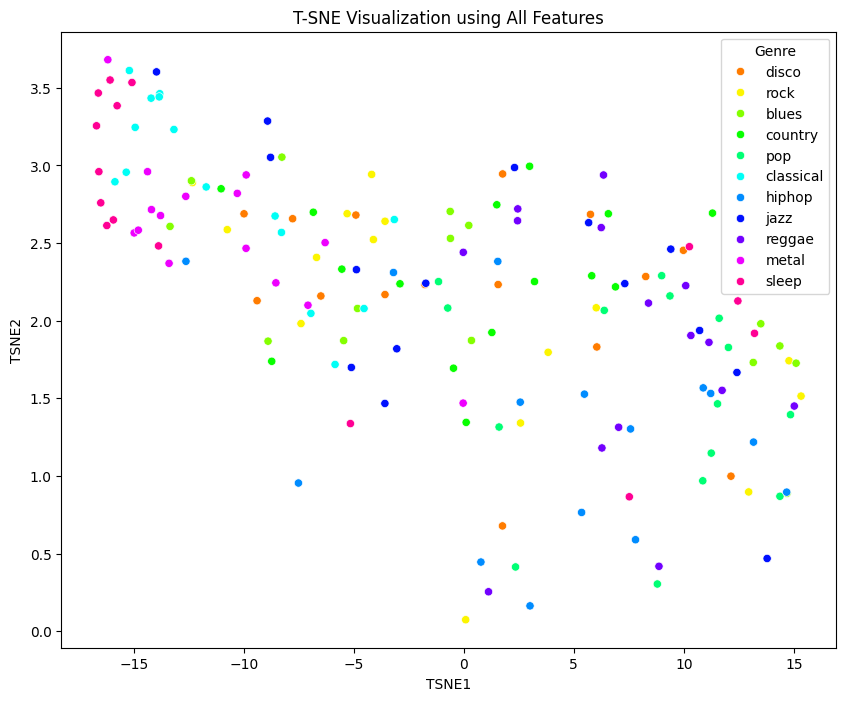

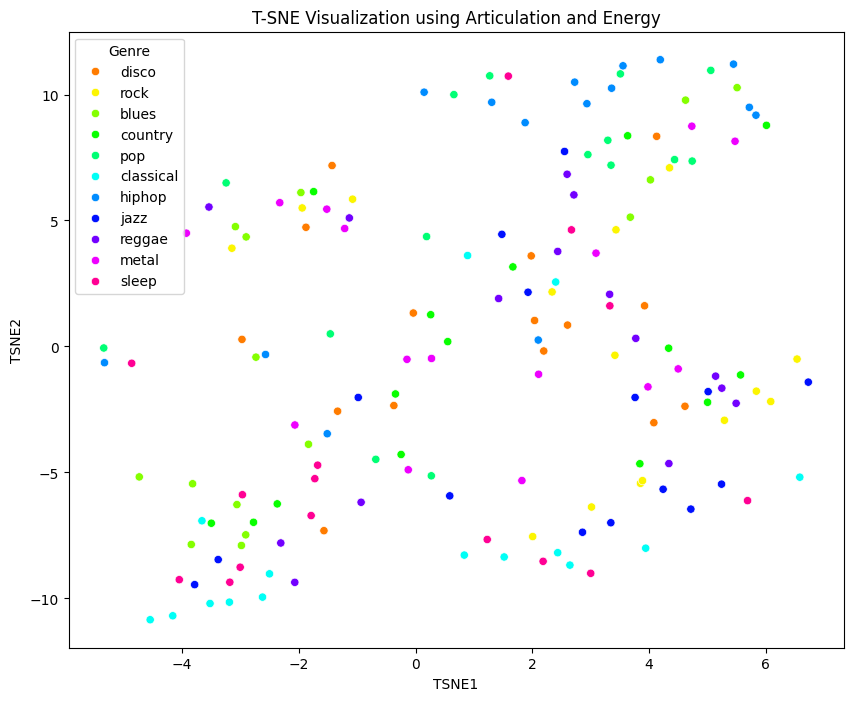

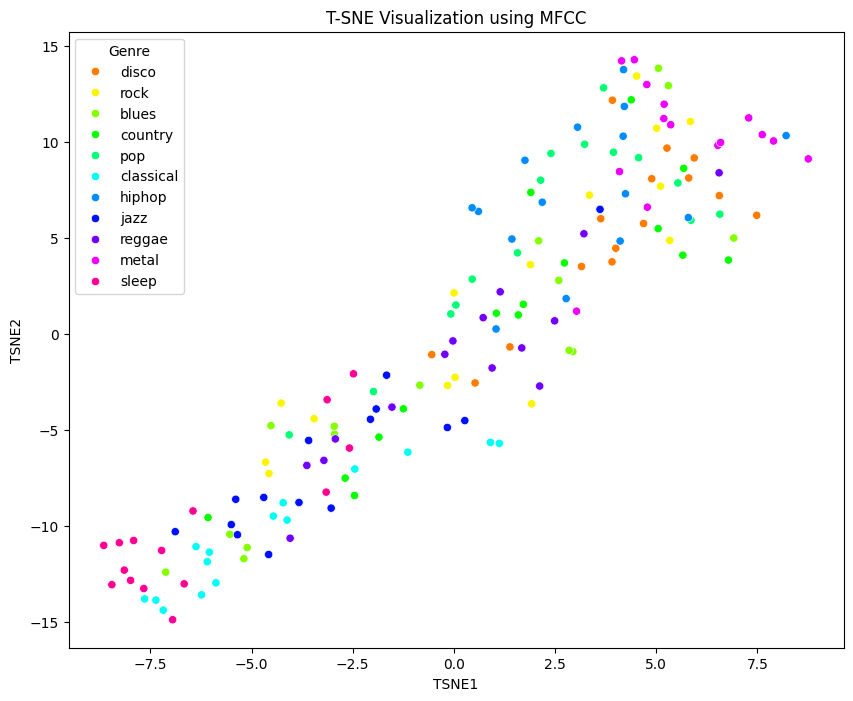

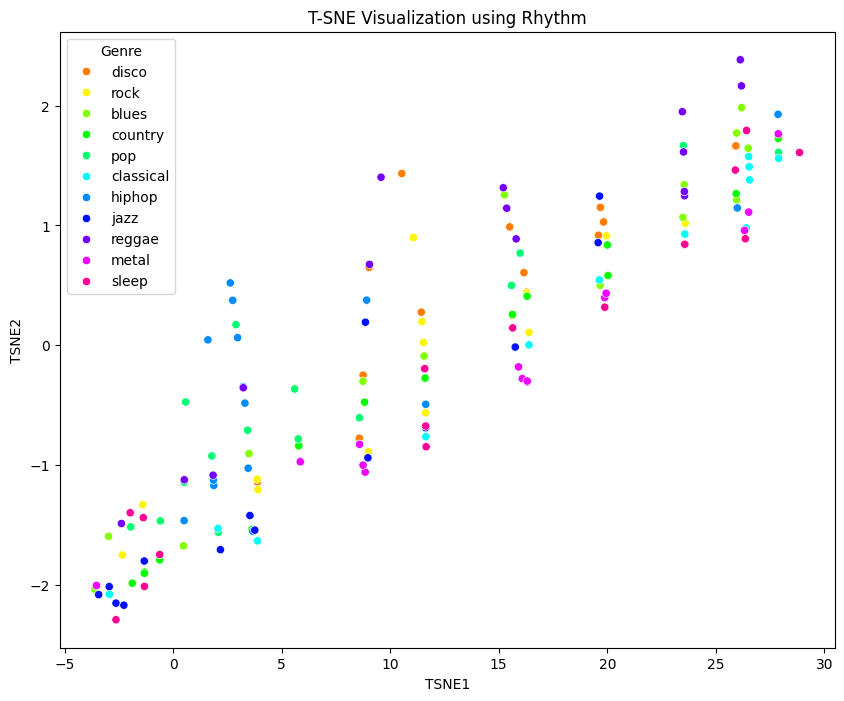

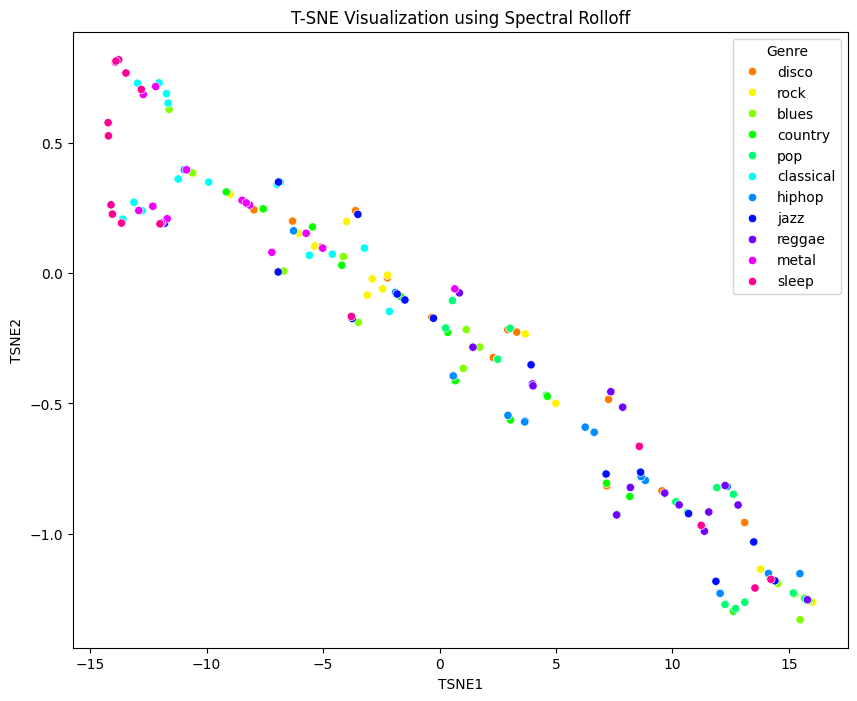

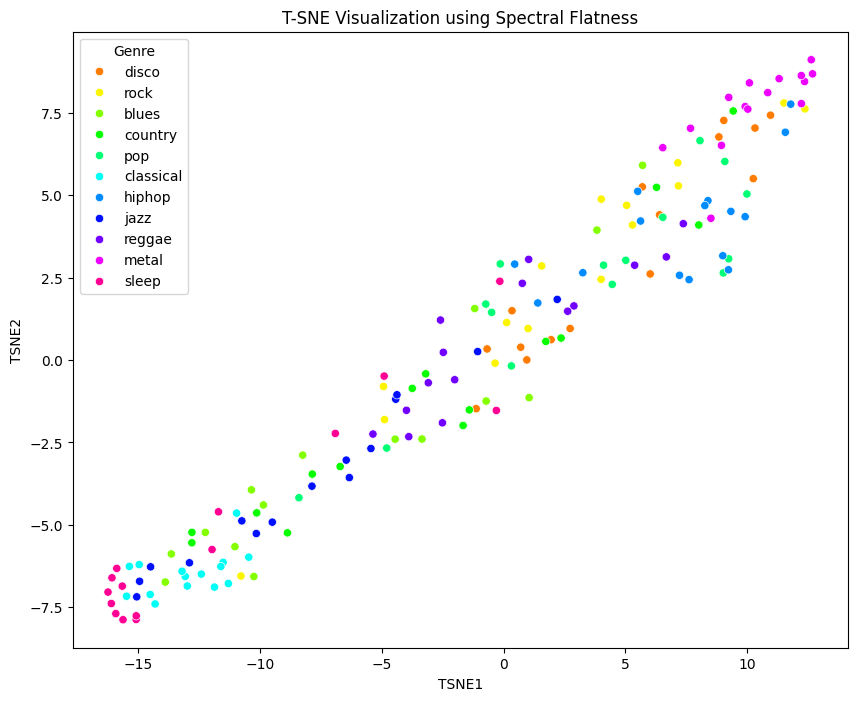

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

# Define feature groups according to the paper
articulation_energy_features = ['asr', 'rms_mean', 'rms_var', 'rms_std']
mfcc_features = [f'mfcc{i}_mean' for i in range(1, 21)]
rhythm_features = ['oenv_mean', 'oenv_var', 'oenv_std', 'tempo']
spectral_rolloff_features = ['rolloff_mean', 'rolloff_var', 'rolloff_std']
spectral_flatness_features = ['flatness_mean', 'flatness_var', 'flatness_std']

# Grouping for visualization
feature_groups = {
    'All Features': features_df.columns[1:-1].tolist(),
    'Articulation and Energy': articulation_energy_features,
    'MFCC': mfcc_features,
    'Rhythm': rhythm_features,
    'Spectral Rolloff': spectral_rolloff_features,
    'Spectral Flatness': spectral_flatness_features
}

# Manually specify a color palette with enough unique colors
unique_labels = features_df['label'].unique()
palette = sns.color_palette("hsv", len(unique_labels))

# Function to plot t-SNE
def plot_tsne(features, title):
    X = features_df[features].values
    y = features_df['label'].values
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X)
    
    tsne_df = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
    tsne_df['label'] = y
    
    plt.figure(figsize=(5,4))
    sns.scatterplot(x='TSNE1', y='TSNE2', hue='label', data=tsne_df, palette=palette)
    plt.title(title)
    plt.legend(loc='best', title='Genre')
    plt.show()

# Generate t-SNE plots for each feature group
for name, features in feature_groups.items():
    plot_tsne(features, f'T-SNE Visualization using {name}')


# Load Audio Datasets

In [26]:
import librosa
import os
import numpy as np
from tqdm import tqdm

def load_and_preprocess_audio(file_path, duration=30, sr=16000):
    # Load the audio file
    audio, _ = librosa.load(file_path, sr=sr, duration=duration, mono=True)
    return audio

# Example: Load and preprocess all files in a directory
sleep_music_dir = '../cache/spotify_sleep_dataset/waveform'

sleep_music_files = [os.path.join(sleep_music_dir, f) for f in os.listdir(sleep_music_dir) if (f.endswith('.wav') or f.endswith('.mp3'))]

# Using tqdm for progress tracking
sleep_music = {_file:load_and_preprocess_audio(_file) for _file in tqdm(sleep_music_files, desc="Processing sleep music files")}


### Extract Musical Features

In [28]:
def calculate_asr(audio):
    rms = librosa.feature.rms(y=audio)
    mean_rms = np.mean(rms)
    silence_ratio = np.mean(rms < mean_rms)
    return silence_ratio

def calculate_energy_features(audio):
    rms = librosa.feature.rms(y=audio)
    return np.mean(rms), np.var(rms), np.std(rms)

def calculate_mfcc_features(audio, sr=16000):
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=20)
    return np.mean(mfccs, axis=1)

def calculate_rhythm_features(audio, sr=16000):
    onset_env = librosa.onset.onset_strength(y=audio, sr=sr)
    tempo, _ = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)
    return tempo, np.mean(onset_env), np.var(onset_env), np.std(onset_env)

def calculate_spectral_rolloff(audio, sr=16000):
    rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr, roll_percent=0.85)
    return np.mean(rolloff), np.var(rolloff), np.std(rolloff)

def calculate_spectral_flatness(audio):
    flatness = librosa.feature.spectral_flatness(y=audio)
    return np.mean(flatness), np.var(flatness), np.std(flatness)

def normalize_features(features):
    scaler = StandardScaler()
    return scaler.fit_transform(features)



# Calculate ASR for all music pieces
# sleep_asr = [calculate_asr(audio) for audio in sleep_music]
# other_asr = [calculate_asr(audio) for audio in other_music]


In [27]:
len(sleep_music)

11482

In [31]:
from tqdm import tqdm

sleep_asr = {audio_file: calculate_asr(audio) for audio_file, audio in tqdm(sleep_music.items(), desc="Calculating ASR")}
sleep_energy = {audio_file: calculate_energy_features(audio) for audio_file, audio in tqdm(sleep_music.items(), desc="Calculating Energy Features")}
sleep_mfcc_features = {audio_file: calculate_mfcc_features(audio) for audio_file, audio in tqdm(sleep_music.items(), desc="Calculating MFCC Features")}
sleep_rhythm_features = {audio_file: calculate_rhythm_features(audio) for audio_file, audio in tqdm(sleep_music.items(), desc="Calculating Rhythm Features")}
sleep_spectral_rolloff = {audio_file: calculate_spectral_rolloff(audio) for audio_file, audio in tqdm(sleep_music.items(), desc="Calculating Spectral Rolloff")}
sleep_spectral_flatness = {audio_file: calculate_spectral_flatness(audio) for audio_file, audio in tqdm(sleep_music.items(), desc="Calculating Spectral Flatness")}

Calculating Spectral Flatness: 100%|██████████| 11482/11482 [04:57<00:00, 38.58it/s]


In [33]:
import pandas as pd

all_features = {}
for audio_file in sleep_music.keys():
    all_features[audio_file] = {
        "ASR": sleep_asr[audio_file],
        "Energy": sleep_energy[audio_file],
        "MFCC": sleep_mfcc_features[audio_file],
        "Rhythm": sleep_rhythm_features[audio_file],
        "Spectral Rolloff": sleep_spectral_rolloff[audio_file],
        "Spectral Flatness": sleep_spectral_flatness[audio_file],
    }

# Convert the dictionary to a DataFrame
df = pd.DataFrame.from_dict(all_features, orient='index')

# Save the DataFrame to a CSV file
df.to_csv("sleep_music_features.csv", index_label="Audio File")

print("CSV file 'sleep_music_features.csv' has been created.")

Calculating ASR:   2%|▏         | 277/11482 [1:46:27<71:46:33, 23.06s/it]


CSV file 'sleep_music_features.csv' has been created.


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score

# Concatenate features for clustering
sleep_features = np.hstack([normalized_sleep_asr, normalized_sleep_energy, sleep_mfcc_features, 
                            sleep_rhythm_features, sleep_spectral_rolloff, sleep_spectral_flatness])

other_features = np.hstack([normalized_other_asr, normalized_other_energy, other_mfcc_features, 
                            other_rhythm_features, other_spectral_rolloff, other_spectral_flatness])

all_features = np.vstack([sleep_features, other_features])
labels = np.array([0] * len(sleep_features) + [1] * len(other_features))

# K-means clustering
kmeans = KMeans(n_clusters=2, random_state=0).fit(all_features)
predicted_labels = kmeans.labels_

# Calculate ARS and Silhouette Coefficient
ars = adjusted_rand_score(labels, predicted_labels)
sc = silhouette_score(all_features, predicted_labels)

print(f'Adjusted Rand Score (ARS): {ars}')
print(f'Silhouette Coefficient (SC): {sc}')

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=30, random_state=0)
tsne_results = tsne.fit_transform(all_features)

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='coolwarm')
plt.title('t-SNE Visualization of Music Features')
plt.show()
